In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Classification

## Data import and cleaning

In [3]:
df = pd.read_csv('data/cruise_cancellations.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 20 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   age                        2000 non-null   int64  
 1   booking_lead_time          2000 non-null   int64  
 2   trip_length                2000 non-null   int64  
 3   cabin_type                 2000 non-null   object 
 4   group_size                 2000 non-null   int64  
 5   loyalty_status             1016 non-null   object 
 6   paid_in_full               2000 non-null   int64  
 7   prior_cruises              2000 non-null   int64  
 8   customer_income            2000 non-null   float64
 9   email_engagement_score     2000 non-null   float64
 10  phone_verified             2000 non-null   int64  
 11  has_insurance              2000 non-null   int64  
 12  on_mailing_list            2000 non-null   int64  
 13  website_visits_last_month  2000 non-null   int64

In [5]:
df.head()

,age,booking_lead_time,trip_length,cabin_type,group_size,loyalty_status,paid_in_full,prior_cruises,customer_income,email_engagement_score,phone_verified,has_insurance,on_mailing_list,website_visits_last_month,survey_participation,preferred_contact_method,travel_history_score,referral_source,gift_certificate_used,canceled
0,56,131,7,Oceanview,5,NaN,1,1,134181.36,0.41,1,0,1,4,No,Phone,62.70,Friend,0,0
1,69,293,5,Oceanview,5,NaN,1,2,104770.24,0.34,1,0,1,1,No,Email,56.59,Friend,0,0
2,46,171,7,Balcony,3,NaN,0,1,109135.01,0.38,1,0,0,3,Yes,Phone,57.58,Ad,0,1
3,32,183,3,Balcony,2,Silver,0,0,80108.53,0.58,0,0,0,2,No,Email,14.75,Search Engine,0,1
4,60,364,10,Oceanview,3,Silver,0,2,73401.55,0.50,1,0,1,3,Partial,Phone,47.49,Ad,0,0


In [6]:
df.isnull().sum()

age                            0
booking_lead_time              0
trip_length                    0
cabin_type                     0
group_size                     0
loyalty_status               984
paid_in_full                   0
prior_cruises                  0
customer_income                0
email_engagement_score         0
phone_verified                 0
has_insurance                  0
on_mailing_list                0
website_visits_last_month      0
survey_participation           0
preferred_contact_method       0
travel_history_score           0
referral_source                0
gift_certificate_used          0
canceled                       0
dtype: int64

In [7]:
df['loyalty_status'].unique()

array([nan, 'Silver', 'Gold', 'Platinum'], dtype=object)

In [8]:
df['loyalty_status'] = df['loyalty_status'].fillna('None')

First, we imported the data and checked that there are 984 null values in the loyalty_status column, which represents visitors with no loyalty status, so we replaced the null value with “None”.

## logistic regression

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [10]:
# 特征列和目标列
features = [
    'age', 'booking_lead_time', 'trip_length', 'cabin_type', 'group_size', 
    'loyalty_status', 'paid_in_full', 'prior_cruises', 'customer_income', 
    'email_engagement_score', 'phone_verified', 'has_insurance', 
    'on_mailing_list', 'website_visits_last_month', 'survey_participation', 
    'preferred_contact_method', 'travel_history_score', 'referral_source', 
    'gift_certificate_used'
]
target = 'canceled'

# 选择特征和目标
X = df[features]
y = df[target]

# 编码分类变量和标准化数值变量
# 定义分类变量列和数值变量列
categorical_cols = ['cabin_type', 'loyalty_status', 'survey_participation', 'preferred_contact_method', 'referral_source']
numeric_cols = ['age', 'booking_lead_time', 'trip_length', 'group_size', 'paid_in_full', 'prior_cruises', 
                'customer_income', 'email_engagement_score', 'phone_verified', 'has_insurance', 
                'on_mailing_list', 'website_visits_last_month', 'travel_history_score', 'gift_certificate_used']

# 使用 Pipeline 处理数值列和分类列
numeric_transformer = 'passthrough'  # 无需标准化 对于数值型特征，不进行处理
categorical_transformer = OneHotEncoder(handle_unknown='ignore')  # 使用独热编码处理分类变量 使用 One-Hot 编码categorical variables

# 创建预处理步骤
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# 4. 创建逻辑回归模型
lr_model = LogisticRegression(max_iter=1000) # 最大迭代次数为 1000

# 5. 创建管道，将预处理和模型训练步骤封装成一个流程
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', lr_model)
])

# 6. 拆分数据集：训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=654)

# 7. 看是否强线性相关
# 设定相关性阈值
threshold = 0.8

# 计算 OneHot 编码后的特征的相关性
X_train_transformed = preprocessor.fit_transform(X_train)
corr_matrix = pd.DataFrame(X_train_transformed).corr()

# 创建一个空的列表用于存储相关性较高的特征对
high_corr_pairs = []

# 遍历相关性矩阵中的每一对特征
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > threshold:
            # 如果相关性高于阈值，添加到列表中
            high_corr_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j]))

# 打印相关性高的特征对
if high_corr_pairs:
    for pair in high_corr_pairs:
        print(f"Feature pair: {pair[0]} and {pair[1]} - Correlation: {pair[2]}")
else:
    print("No significant multicollinearity.\n")


# 8. 训练模型
pipeline.fit(X_train, y_train)


No significant multicollinearity.



/home/ethanchen/AD654-Sp25A3-Project/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', 'passthrough',
                                                  ['age', 'booking_lead_time',
                                                   'trip_length', 'group_size',
                                                   'paid_in_full',
                                                   'prior_cruises',
                                                   'customer_income',
                                                   'email_engagement_score',
                                                   'phone_verified',
                                                   'has_insurance',
                                                   'on_mailing_list',
                                                   'website_visits_last_month',
                                                   'travel_history_score',
                                                   'gift_certificate_used']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['cabin_type',
                                                   'loyalty_status',
                                                   'survey_participation',
                                                   'preferred_contact_method',
                                                   'referral_source'])])),
                ('classifier', LogisticRegression(max_iter=1000))])

For the purpose of classification, we build a logistic regression model to predict whether a cruise booking will be canceled, using the loyalty_status column as the target variable and the other columns as features.  As we noticed before, there're different type of variables in features, so we separate it into categorical_cols and numeric_cols. Categorical features are one-hot encoded, while numerical features remain unchanged. Using Pipeline and ColumnTransformer, We created a streamlined preprocessing and modeling workflow. It splits the data into training and testing sets and checks for multicollinearity among transformed features by analyzing their correlation matrix. Finally, the full pipeline is trained on the training dataset.

In [11]:
# 9. 预测结果并评估模型
y_pred = pipeline.predict(X_test)

# 输出准确率和分类报告
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.72

Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.93      0.82       284
           1       0.55      0.21      0.30       116

    accuracy                           0.72       400
   macro avg       0.64      0.57      0.56       400
weighted avg       0.68      0.72      0.67       400



*Recall* : Of all the actual positives, how much did you capture? 

As we can see, the model's accuracy is 0.72. It looks good that the model is 72% correct overall. For those visitors whose booking was canceled, the recall is 0.21, which means that Only about 1/5 of the customers who would cancel are identified. And for those visitors who won't cancle their booking, the recall is 0.93, means that the model accurately identifies the vast majority of customers who will complete the booking.

In [12]:
# 特征列和目标列
features = [
    'age', 'booking_lead_time', 'trip_length', 'cabin_type', 'group_size', 
    'loyalty_status', 'paid_in_full', 'prior_cruises', 'customer_income', 
    'email_engagement_score', 'phone_verified', 'has_insurance', 
    'on_mailing_list', 'website_visits_last_month', 'survey_participation', 
    'preferred_contact_method', 'travel_history_score', 'referral_source', 
    'gift_certificate_used'
]
target = 'canceled'

# 选择特征和目标
X = df[features]
y = df[target]

# 编码分类变量和标准化数值变量
# 定义分类变量列和数值变量列
categorical_cols = ['cabin_type', 'loyalty_status', 'survey_participation', 'preferred_contact_method', 'referral_source']
numeric_cols = ['age', 'booking_lead_time', 'trip_length', 'group_size', 'paid_in_full', 'prior_cruises', 
                'customer_income', 'email_engagement_score', 'phone_verified', 'has_insurance', 
                'on_mailing_list', 'website_visits_last_month', 'travel_history_score', 'gift_certificate_used']

# 使用 Pipeline 处理数值列和分类列
numeric_transformer = 'passthrough'  # 无需标准化 对于数值型特征，不进行处理
categorical_transformer = OneHotEncoder(handle_unknown='ignore')  # 使用独热编码处理分类变量 使用 One-Hot 编码categorical variables

# 创建预处理步骤
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# 4. 创建逻辑回归模型
lr_balanced_model = LogisticRegression(max_iter=1000, class_weight='balanced') # 最大迭代次数为 1000, 使用类权重

# 5. 创建管道，将预处理和模型训练步骤封装成一个流程
pipeline_balanced = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', lr_balanced_model)
])

# 6. 拆分数据集：训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=654)

# 7. 看是否强线性相关
# 设定相关性阈值
threshold = 0.8

# 计算 OneHot 编码后的特征的相关性
X_train_transformed = preprocessor.fit_transform(X_train)
corr_matrix = pd.DataFrame(X_train_transformed).corr()

# 创建一个空的列表用于存储相关性较高的特征对
high_corr_pairs = []

# 遍历相关性矩阵中的每一对特征
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > threshold:
            # 如果相关性高于阈值，添加到列表中
            high_corr_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j]))

# 打印相关性高的特征对
if high_corr_pairs:
    for pair in high_corr_pairs:
        print(f"Feature pair: {pair[0]} and {pair[1]} - Correlation: {pair[2]}")
else:
    print("No significant multicollinearity.\n")


# 8. 训练模型
pipeline_balanced.fit(X_train, y_train)

# 9. 预测结果并评估模型
y_pred_balanced = pipeline_balanced.predict(X_test)

# 输出准确率和分类报告
print("Accuracy:", accuracy_score(y_test, y_pred_balanced))
print("\nClassification Report:\n", classification_report(y_test, y_pred_balanced))

No significant multicollinearity.

Accuracy: 0.6925

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.68      0.76       284
           1       0.48      0.72      0.58       116

    accuracy                           0.69       400
   macro avg       0.67      0.70      0.67       400
weighted avg       0.75      0.69      0.71       400



/home/ethanchen/AD654-Sp25A3-Project/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [13]:
# 拟合 & 预测
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

pipeline_balanced.fit(X_train, y_train)
y_pred_balanced = pipeline_balanced.predict(X_test)

# 输出对比结果
print("==== Logistic Regression ====")
print(classification_report(y_test, y_pred))

print("==== Balanced Logistic Regression ====")
print(classification_report(y_test, y_pred_balanced))


==== Logistic Regression ====
              precision    recall  f1-score   support

           0       0.74      0.93      0.82       284
           1       0.55      0.21      0.30       116

    accuracy                           0.72       400
   macro avg       0.64      0.57      0.56       400
weighted avg       0.68      0.72      0.67       400

==== Balanced Logistic Regression ====
              precision    recall  f1-score   support

           0       0.86      0.68      0.76       284
           1       0.48      0.72      0.58       116

    accuracy                           0.69       400
   macro avg       0.67      0.70      0.67       400
weighted avg       0.75      0.69      0.71       400



/home/ethanchen/AD654-Sp25A3-Project/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/ethanchen/AD654-Sp25A3-Project/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stab

Because our main purpose is to know what kinds of passengers are most likely to cancel, and the 0.21 recall is obviously not good enough. So we used logistic regression with class_weight='balanced' to handle this. From the results, we can see that the recognition ability of the new model for “Cancel (Class 1)” increases from 21% to 72%, which is a significant improvement. Although the accuracy decreases slightly, the F1-score improves significantly from 0.30 to 0.58, which indicates that the new model is more reliable.

## Analysis

/home/ethanchen/AD654-Sp25A3-Project/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


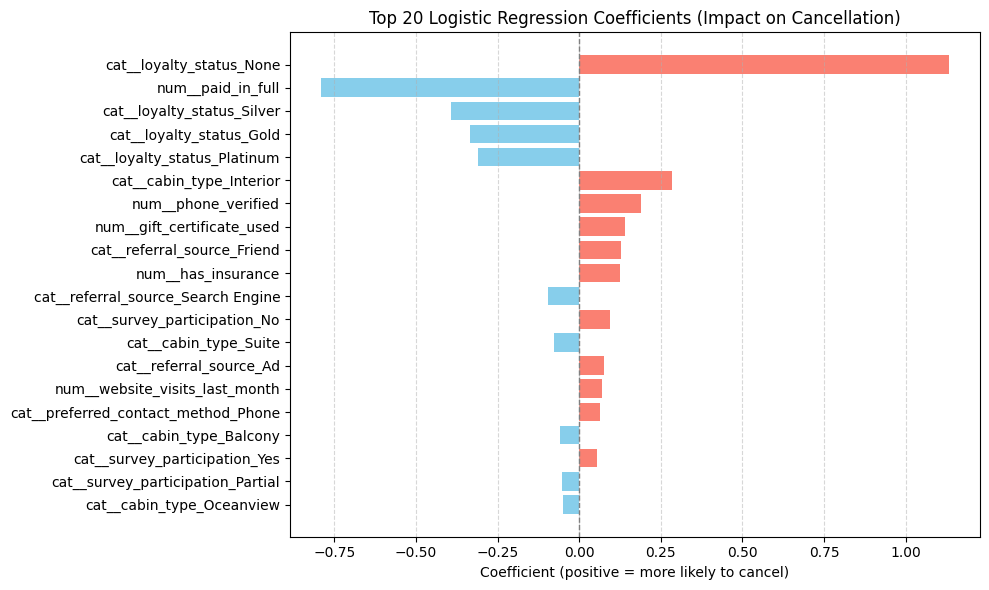

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# 定义模型
lr_balanced_model = LogisticRegression(max_iter=1000, class_weight='balanced')

# 创建 pipeline
lr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', lr_balanced_model)
])

# 拟合模型
lr_pipeline.fit(X_train, y_train)

# 获取特征名称
feature_names = lr_pipeline.named_steps['preprocessor'].get_feature_names_out()

# 逻辑回归系数（带正负号）
lr_coef = lr_pipeline.named_steps['classifier'].coef_[0]

# 取前 20 个重要特征（逻辑回归按绝对值排序）
top_n = 20
lr_top_idx = np.argsort(np.abs(lr_coef))[::-1][:top_n]

# ---------- 逻辑回归可视化 ----------
plt.figure(figsize=(10, 6))
colors = ['salmon' if coef > 0 else 'skyblue' for coef in lr_coef[lr_top_idx][::-1]]
plt.barh(range(top_n), lr_coef[lr_top_idx][::-1], color=colors)
plt.yticks(range(top_n), [feature_names[i] for i in lr_top_idx][::-1])
plt.axvline(0, color='gray', linestyle='--', linewidth=1)
plt.title("Top 20 Logistic Regression Coefficients (Impact on Cancellation)")
plt.xlabel("Coefficient (positive = more likely to cancel)")
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
#plt.savefig("logistic_regression_coefficients.png", dpi=300)
plt.show()


By analyzing the top 20 most important characteristics provided by the logistic regression, we can see that loyalty status is the most influential variable in the logistic regression, with visitors with a loyalty status of “None” being the most likely to cancel a reservation, while having any kind of loyalty status makes them less likely to cancel a reservation.

In addition, whether or not they paid in full is also an important factor, as tourists are very unlikely to cancel a booking if they paid in full.Also, the type of cabin can have an impact. If a visitor has an “Interior” cabin, they are more likely to cancel their booking than visitors with other cabin types.

In summary, While there are other factors that come into play, in general, the more money a visitor spends, the less likely they are to cancel a trip; the less money a visitor spends, the more likely they are to cancel a trip.

From the previous analysis, it can be concluded that visitors with the following characteristics are most likely to cancel their bookings:

1. No loyalty status.

2. Partial payments or lower overall spending.

3. Booked in "Interior" cabins.

4. Budget-conscious or first-time customers.

So first, Lobster Land management can flag these groups in the reservation system and prepare ahead of time for the possibility of them canceling.

In addition, Lobster Land management should introduce incentives centered on consumer spending to reduce cancellations.

As for the loyalty programs, Offering discounts for joining the loyalty program at booking. Reward loyal customers with points for non-cancellation, redeemable for upgrades or discounts on future trips is also a good way.

As for the payment strategies, Lobster Land can Offer 5-10% discounts for paying in full upfront, and introduce a small non-refundable deposit for budget bookings to deter cancellations. Such customers often choose not to cancel their reservations due to the sunk costs caused by these non-refundable deposits.

As for the cabin type, Lobster Land can provide dynamic offers, give Interior cabin bookers with discounted upgrades to higher-tier cabins closer to the trip date. Also, Lobster Land can provides bundle packages, combining Interior cabins with non-refundable add-ons like dining packages to increase cancellation costs.

At the same time, we have found that many of the visitors with a tendency to cancel have verified their phone, got the cruise program primarily through friends, advertisements, or websites, and most have not engaged in customer research. So Lobster Land could upgrade the content of its ads and website by replacing text ads with short videos that show real cruise experiences. In addition, Lobster Land can provide an “invitation code” to visitors who have already purchased a ticket, so that if someone else uses the code, they can receive points, discounts or vouchers. Lobster Land should also conduct more post-cancellation surveys to collect information on the reasons for cancellations.